In [1]:
from urllib.request import urlopen

# read web data
url = 'https://waterdata.usgs.gov/nwis/dv?cb_00010=on&format=rdb&site_no=11417500&referred_module=sw&period=&begin_date=1965-02-18&end_date=2005-02-16'
webpage = urlopen(url)
charset_encoding = webpage.info().get_content_charset()
webpage = webpage.read().decode(charset_encoding)

In [2]:
import pandas as pd

# wrangle and transform to pd series
splitpage = webpage.split(sep='\n')
header , data = splitpage[28].split(sep='\t'), []

for line in splitpage[30:-1]: 
	data.append(line.split(sep='\t'))

data_series = pd.Series(data)

In [3]:
import numpy as np

# transform to pd dataframe
df = pd.DataFrame(data_series.tolist(), columns=splitpage[28].split(sep='\t'), index=data_series.index)

# wrangle: fill and drop nan, reset index, rename columns
df['10733_00010_00001'].replace('',np.nan,inplace=True)
df.dropna(subset = ['10733_00010_00001'], inplace=True)
df = df.reset_index(drop=True)
df.columns = ['agency_cd', 'site_no', 'datetime', 'max_temp', 'max_temp_code', 'min_temp', 'min_temp_code']

In [4]:
# table of record counts and date range
df.groupby(df.datetime.str[0:4]).agg({'max_temp':'count'})

,max_temp
datetime,
1965,317
1966,365
1967,364
1968,355
1969,354
1970,343
1971,365
1972,366
1973,314


In [5]:
# get beginning date ranges for the 2 obvious segments of data using counts
idx_end_1979 = (-47 - 366 - (365 * 3) - 60) - 1
idx_begin_2000 = idx_end_1979 + 1
df['datetime'].iloc[0],df['datetime'].iloc[idx_end_1979], df['datetime'].iloc[idx_begin_2000], df['datetime'].iloc[-1]

('1965-02-18', '1979-04-30', '2000-11-02', '2005-02-16')

In [6]:
# translate segment date ranges into indeces and slice df
idx_lower_df1 = df.loc[df['datetime'] == '1965-02-18'].index.tolist()
idx_upper_df1 = df.loc[df['datetime'] == '1979-04-30'].index.tolist()

idx_lower_df2 = df.loc[df['datetime'] == '2000-11-02'].index.tolist()
idx_upper_df2 = df.loc[df['datetime'] == '2005-02-16'].index.tolist()

df1 = df.iloc[idx_lower_df1[0]:idx_upper_df1[0]]
df2 = df.iloc[idx_lower_df2[0]:idx_upper_df2[0]]

In [7]:
# transform into np arrays for sinusoidal regression modeling
y_data_df1 = np.array(df1['max_temp'].tolist(),dtype = np.float32)
y_data_df2 = np.array(df2['max_temp'].tolist(),dtype = np.float32)

# represent dates as continuous variable of same length
x_data_df1 = np.array(list(range(1,len(y_data_df1) + 1)))
x_data_df2 = np.array(list(range(1,len(y_data_df2) + 1)))

In [8]:
# define sinusoidal fxn with scale var so final value maps to roughly 2pi
scale = 2 * np.pi / 365

def test_func(x, a, b, c, d):
    return a * np.sin(b * x * scale + c) + d

# define r-squared function
def r_func(y, y_predict):
    residuals = y - y_predict
    ss_residuals = np.sum(residuals**2)
    ss_total = np.sum((y-np.mean(y))**2)
    r_sq = 1 - (ss_residuals / ss_total)
    return r_sq

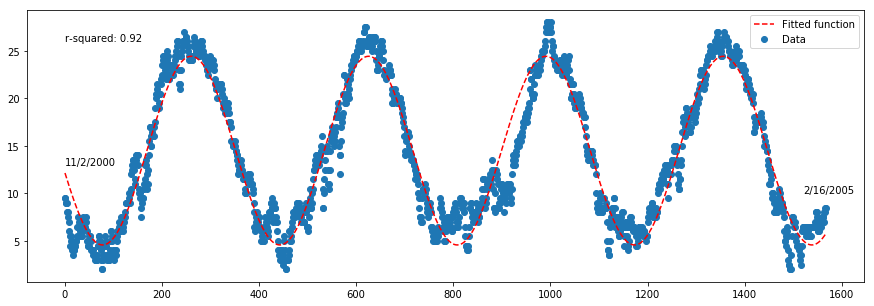

In [10]:
from scipy import optimize
import matplotlib.pyplot as plt

# perform regression and plot, start with df2 because data is more complete
params, params_covariance = optimize.curve_fit(test_func, x_data_df2, y_data_df2, p0=None)

# calculate coef of determination
r_sq = r_func(y_data_df2, test_func(x_data_df2, params[0], params[1], params[2], params[3]))
              
# plot
plt.figure(figsize = (15, 5))
plt.scatter(x_data_df2, y_data_df2, label = 'Data')
plt.plot(x_data_df2, test_func(x_data_df2, params[0], params[1], params[2], params[3]), 'r--',label = 'Fitted function')
plt.legend(loc = 'best')
plt.annotate('r-squared: '+str(round(r_sq,2)),xy=(0,26))
plt.annotate('11/2/2000',xy=(0,13))
plt.annotate('2/16/2005',xy=(1520,10))
plt.show()

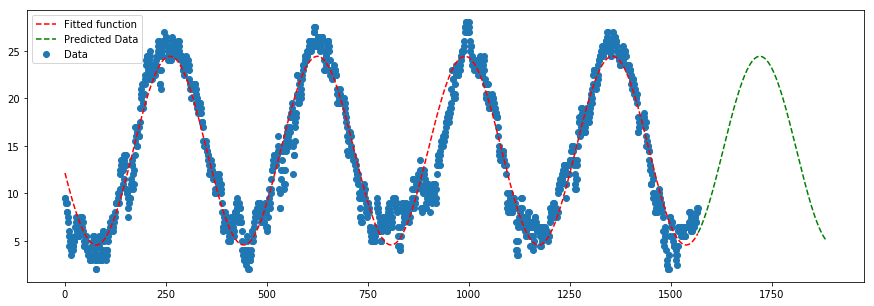

In [11]:
# use model to predict the rest of 2005 and plot
date1 = x_data_df2[-1] + 1 # represents 2/17/2005
date2 = date1 + 317 # represents 12/31/2005

predict_x_data = np.arange(date1,date2,1)
predict_y_data = np.array(test_func(predict_x_data, params[0], params[1], params[2], params[3]))

plt.figure(figsize=(15, 5))
plt.scatter(x_data_df2, y_data_df2, label='Data')
plt.plot(x_data_df2, test_func(x_data_df2, params[0], params[1], params[2], params[3]), 'r--',label='Fitted function')
plt.plot(predict_x_data,predict_y_data, 'g--',label='Predicted Data')
plt.legend(loc='best')
plt.show()

In [12]:
import datetime

predict_x_data_date_objs = np.arange((np.datetime64('2005-02-17')), np.datetime64('2005-12-31')).tolist()

predict_x_data_dates = []
for date in predict_x_data_date_objs:
    predict_x_data_dates.append(date.strftime("%#m/%#d/%Y"))

predict_df = pd.DataFrame({'x_date': predict_x_data_dates,'y': predict_y_data.round(1)})

min, max = predict_df.loc[predict_df['y'].idxmin(), ['x_date','y']].tolist(), predict_df.loc[predict_df['y'].idxmax(), ['x_date','y']].tolist()

min, max

(['12/29/2005', 5.1], ['7/12/2005', 24.4])

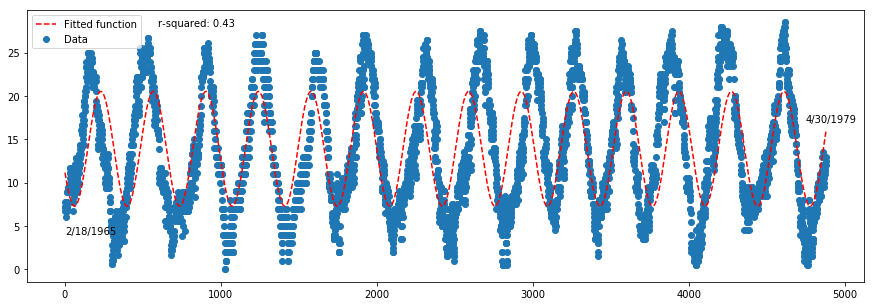

In [13]:
# for df1 - which is larger span but incomplete data - perform regression for purpose of fit stats
scale = 2 * np.pi / 351 # reduce scaling due to data integrity
params, params_covariance = optimize.curve_fit(test_func, x_data_df1, y_data_df1, p0=None)

# calculate coef of determination
r_sq = r_func(y_data_df1,test_func(x_data_df1, params[0], params[1], params[2], params[3]))

# plot
plt.figure(figsize=(15, 5))
plt.scatter(x_data_df1, y_data_df1, label='Data')
plt.plot(x_data_df1, test_func(x_data_df1, params[0], params[1], params[2], params[3]), 'r--',label='Fitted function')
plt.legend(loc='best')
plt.annotate('r-squared: '+str(round(r_sq,2)),xy=(600,28))
plt.annotate('2/18/1965',xy=(0,4))
plt.annotate('4/30/1979',xy=(4750,17))
plt.show()
